In [31]:
%reload_ext autoreload
%autoreload 2

In [32]:
import os, sys
import re
import json
import glob
import datetime
import nltk
import spacy
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from collections import Counter

import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob
from pprint import pprint
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from pymongo import MongoClient
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import psycopg2
from pathlib import Path
from dotenv import dotenv_values

In [33]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [34]:
loader = SlackDataLoader("../src/anonymized/")
channel = loader.get_channels()
all_data = []
for i in channel:
    data = loader.slack_parser(f"../src/anonymized/{i['name']}/")
    all_data.append(data)

df = pd.concat(all_data, ignore_index=True)
# df.head(50)

### Seting datbase connection requirnments

In [35]:
env_path = Path('.') / '.env'
env_values = dotenv_values(dotenv_path=env_path)

db_password = env_values["POSTGRES_PASSWORD"]
encoded_password = quote_plus(db_password)
database = env_values["POSTGRES_DB"]
user = env_values["POSTGRES_USER"]
server = env_values["POSTGRES_SERVER"]

## EDA Analaysis

In [36]:
# Who are the top 10  users by replay count?
user_reply_counts = df.groupby('sender_name')['reply_count'].sum().sort_values(ascending=False)
top_10_users = user_reply_counts.head(10)
pd.DataFrame({'sender_name': top_10_users.index,
'reply_count': top_10_users.values})

,sender_name,reply_count
0,Cristian Wilson,620
1,Vanessa Norman,462
2,Brian Odom,367
3,Brenda Hernandez,307
4,Michelle Lewis,306
5,April Lucas,302
6,Travis Butler,299
7,Amy Leon,282
8,Joshua Rhodes,247
9,Brady Rhodes,242


In [37]:
# Who are the bottom 10  users by replay count?
user_reply_counts = df.groupby('sender_name')['reply_count'].sum().sort_values(ascending=False)
bottom_10_users = user_reply_counts.tail(10)
pd.DataFrame({'sender_name': bottom_10_users.index,
'reply_count': bottom_10_users.values})

,sender_name,reply_count
0,Randy Miller,4
1,Leah Newton,2
2,Blake Scott,0
3,Patrick Hernandez,0
4,Patricia Thomas,0
5,Slackbot,0
6,Christopher Case,0
7,Holly Whitaker,0
8,Erica Munoz,0
9,David Scott,0


In [38]:
# Who are the top 10  users by mention count?
mentioned_users = utils.get_tagged_users(df)
loader.get_users()

users_map = loader.get_user_map()[0]
user_names_list = pd.DataFrame({
    'user_id' : list(users_map.keys()),
    'user_name': list(users_map.values())
})

user_ids = []
for id in mentioned_users:
	if id:
		user_ids.append(id[0][1:])

all_mentioned_ids = pd.DataFrame({'user_id': user_ids})


mentioned_users = user_names_list.merge(all_mentioned_ids, on='user_id', how='inner')
mentioned_users_count = mentioned_users.groupby('user_id').value_counts()
top_10_user = mentioned_users_count.sort_values(ascending=False).head(10)
pd.DataFrame(top_10_user)

,,count
user_id,user_name,
U03V1AM5TFA,Vanessa,174
U03TEPYRM2P,Garrett,165
U03UVHCV6KB,Travis,149
U03UUR571A5,Amy,143
U03UG32J3PC,April,139
U03UG4Q7V42,Phillip,111
U03UD68RQH3,Brady,110
U03UJGP0C68,Judith,109
U03UJKJGRAQ,Brian,102


In [39]:
# Who are the bottom 10  users by mention count?
bottom_10_user = mentioned_users_count.sort_values(ascending=False).tail(10)
pd.DataFrame(bottom_10_user)

,,count
user_id,user_name,
U03U1J51VFZ,Cheryl,11
U03UG569P7U,Melissa,7
U03UJGFG2HJ,Vernon,6
U03UKGSDGSG,Leah,5
U03U1FQKEMV,Steven,3
U03UD63A8PP,Randy,3
U03TNP8Q8CT,Bethany,3
U03UG1RTXAP,Carol,3
U03UYNR4TS4,Patrick,2


In [40]:
# Who are the top users by Message count?
user_message_counts = df['sender_name'].value_counts()
top_10_users = user_message_counts.head(10)
pd.DataFrame({'sender_name': top_10_users.index, 'message_count': top_10_users.values}) 

,sender_name,message_count
0,Vanessa Norman,1288
1,Amy Leon,1150
2,Travis Butler,1075
3,April Lucas,991
4,Brenda Hernandez,843
5,Cristian Wilson,831
6,Phillip Atkins,754
7,Brady Rhodes,641
8,Judith Bolton,574
9,Joshua Rhodes,519


In [41]:
# Who are the bottom users by Message count?
bottom_10_users = user_message_counts.tail(10)
pd.DataFrame({'sender_name': bottom_10_users.index, 'message_count': bottom_10_users.values})

,sender_name,message_count
0,Leah Newton,10
1,Patricia Thomas,8
2,Randy Miller,7
3,Patrick Hernandez,5
4,Slackbot,3
5,Erica Munoz,1
6,Christopher Case,1
7,Holly Whitaker,1
8,David Scott,1
9,Blake Scott,1


In [42]:
# Stroring message_count in a table named 'message_count'
engine = create_engine(f'postgresql://{user}:{encoded_password}@{server}/{database}')
user_message_counts.to_sql('message_count', engine, if_exists='replace')
engine.dispose()

In [43]:
all_reactions = []

# Provide a list of channel names
channel_list = loader.get_channels()
channel_names = [channel_list[i]['name'] for i in range(len(channel_list))]

# Iterate through each channel name and parse reaction data
for channel_name in channel_names:
    data = loader.parse_slack_reaction(channel_name + "/")
    all_reactions.append(data)

reaction_df = pd.concat(all_reactions, ignore_index=True)

# reaction_df

In [44]:
# Who are the bottom 10 users by Reaction count?

# Function to generate user mapping
def generate_user_mapping(loader):
    users_map = loader.get_user_map()[0]
    user_names_list = pd.DataFrame({
        'user_id': list(users_map.keys()),
        'user_name': list(users_map.values())
    })
    return user_names_list

# Function to get bottom users by reaction count with names
def get_bottom_users_by_reaction(reaction_df, loader, N=10):
    user_reaction_counts = reaction_df['user_id'].value_counts()
    bottom_N_users = user_reaction_counts.tail(N)
    
    # Generate user mapping
    user_names_list = generate_user_mapping(loader)
    
    bottom_users_with_names = pd.DataFrame({
        'user': bottom_N_users.index,
        'reaction_count': bottom_N_users.values
    })
    
    # Merge with user mapping to get usernames
    bottom_users_with_names = bottom_users_with_names.merge(user_names_list, left_on='user', right_on='user_id', how='left')
    bottom_users_with_names = bottom_users_with_names[['user_name', 'reaction_count']].rename(columns={'user_name': 'user'})
    
    return bottom_users_with_names

bottom_10_users_with_names = get_bottom_users_by_reaction(reaction_df, loader)
pd.DataFrame(bottom_10_users_with_names)

,user,reaction_count
0,Samuel,15
1,Steven,11
2,Michele,11
3,Melissa,7
4,Leah,7
5,Patricia,5
6,Patrick,4
7,Vernon,4
8,Christopher,1
9,Randy,1


In [45]:
# Who are the top 10 users by Reaction count?

# Function to generate user mapping
def generate_user_mapping(loader):
    users_map = loader.get_user_map()[0]
    user_names_list = pd.DataFrame({
        'user_id': list(users_map.keys()),
        'user_name': list(users_map.values())
    })
    return user_names_list

# Function to get top users by reaction count with names
def get_top_users_by_reaction(reaction_df, loader, N=10):
    user_reaction_counts = reaction_df['user_id'].value_counts()
    top_N_users = user_reaction_counts.head(N)
    
    # Generate user mapping
    user_names_list = generate_user_mapping(loader)
    
    top_users_with_names = pd.DataFrame({
        'user': top_N_users.index,
        'reaction_count': top_N_users.values
    })
    
    # Merge with user mapping to get usernames
    top_users_with_names = top_users_with_names.merge(user_names_list, left_on='user', right_on='user_id', how='left')
    top_users_with_names = top_users_with_names[['user_name', 'reaction_count']].rename(columns={'user_name': 'user'})
    
    return top_users_with_names

# Example usage:
# Assuming reaction_df and loader are defined
top_10_users_with_names = get_top_users_by_reaction(reaction_df, loader)
pd.DataFrame(top_10_users_with_names)

,user,reaction_count
0,Vanessa,427
1,April,335
2,Amy,332
3,Travis,248
4,Cristian,243
5,Judith,236
6,Brady,223
7,Phillip,222
8,Joshua,196
9,Brian,190


In [46]:
# Stroring user_reaction_counts in a table named 'user_reaction_counts'
engine = create_engine(f'postgresql://{user}:{encoded_password}@{server}/{database}')
top_10_users_with_names.to_sql('user_reaction_counts', engine, if_exists='replace')
engine.dispose()

In [61]:
# What are the top 10 messages by Replies?
# processes = utils.process_msgs(all)
# print(processes)

## Topic Modeling and Sentiment Analysis

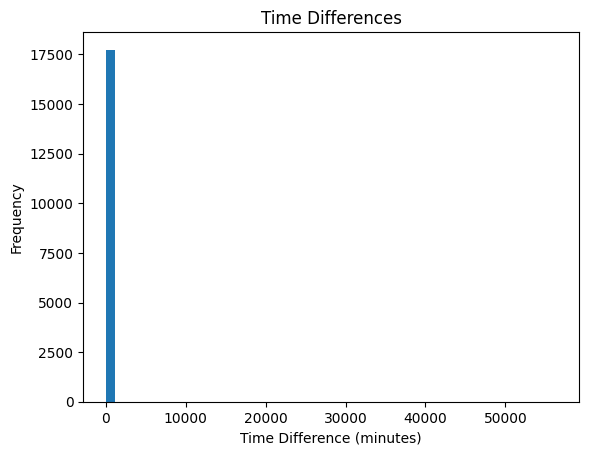

In [47]:
# distribution of time differences
df['msg_sent_time'] = pd.to_datetime(df['msg_sent_time'], unit='s')  # convert to datetime
# df['msg_sent_time']
df = df.sort_values('msg_sent_time')
df['time_diff'] = df['msg_sent_time'].diff()
# print(df['time_diff'].describe())

df['time_diff_minutes'] = df['time_diff'].dt.total_seconds() / 60 # Convert the time differences to minutes

# Plot a histogram of the time differences
plt.hist(df['time_diff_minutes'].dropna(), bins=50)
plt.title('Time Differences')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Frequency')
plt.show()

In [48]:
stop_words = stopwords.words('english')

In [49]:
data = df['msg_content'].values.tolist()
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub(r'\s+', ' ', sent) for sent in data]
data = [re.sub(r"\'", "", sent) for sent in data]
data = [re.sub(r"@U\w+", "", sent) for sent in data]

def lemmatization(texts, allowed_postags = ["NOUN", "ADJ", "VERB", "ADV", "PRON", "DET", "ADP"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

lemmatized_texts = lemmatization(data)
print(lemmatized_texts[1][0:50])

thank you


In [50]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['glad', 'make', 'it', 'to', 'the', 'week', 'program', 'like', 'thank']


In [51]:
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

['glad', 'make', 'it', 'to', 'the', 'week', 'program', 'like', 'thank']


In [52]:
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [53]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [56]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
# pyLDAvis.save_html(vis, "lda_visualization.html")
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.388318  0.251327       1        1  22.602140
6      0.112700  0.411623       2        1  12.875540
8     -0.343672 -0.254317       3        1  11.727478
7     -0.239421  0.396256       4        1  11.697696
9      0.194727 -0.403852       5        1   9.440952
0     -0.143028  0.133572       6        1   7.851751
5     -0.099307 -0.391372       7        1   7.238999
2     -0.430687  0.029628       8        1   6.010703
3      0.154429 -0.062801       9        1   5.919268
4      0.405941 -0.110065      10        1   4.635473, topic_info=          Term         Freq        Total Category  logprob  loglift
6          the  7347.000000  7347.000000  Default  30.0000  30.0000
9          you  4161.000000  4161.000000  Default  29.0000  29.0000
14          we  2234.000000  2234.000000  Default  28.0000  28.0000
1           it  2504.000000  2504.000000  Default  27.0000  27.0000
258        joy  1718.000000  1718.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
506       info    52.100154    53.028165  Topic10  -4.7268   3.0538
1390     worry    51.188069    52.115516  Topic10  -4.7445   3.0535
786   solution    50.551537    51.478907  Topic10  -4.7570   3.0533
486        utc    45.960543    46.887867  Topic10  -4.8522   3.0515
789     handle    44.004550    44.931972  Topic10  -4.8957   3.0506

[333 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
337       1  0.996727      about
51        3  0.987821    academy
76        2  0.989531     access
213       8  0.981168    account
306       8  0.994498   activity
...     ...       ...        ...
168       3  0.995240        www
1118      8  0.988213  yesterday
525       7  0.984217        yet
9         3  0.999679        you
94        7  0.999094       your

[305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 9, 8, 10, 1, 6, 3, 4, 5])

In [57]:
for i, channel_data in enumerate(all_data):
    combined_text = channel_data['msg_content'].tolist()  # Extract text data from 'msg_content' column
    # Preprocess text data
    lemmatized_texts = lemmatization(combined_text)
    data_words = gen_words(lemmatized_texts)
    
    # Apply topic modeling on the data_words
    id2word = corpora.Dictionary(data_words)
    corpus = [id2word.doc2bow(text) for text in data_words]
    
    top_topics = lda_model.show_topics(num_topics=10, num_words=5)
    print(f"Top 10 topics for Channel {i+1}:")
    for topic_number, words in top_topics:
        print(f"Topic {topic_number}: {words}")


Top 10 topics for Channel 1:
Topic 0: 0.064*"use" + 0.050*"need" + 0.031*"find" + 0.026*"file" + 0.024*"those"
Topic 1: 0.256*"the" + 0.096*"in" + 0.069*"of" + 0.041*"to" + 0.039*"what"
Topic 2: 0.293*"we" + 0.085*"now" + 0.079*"so" + 0.059*"guy" + 0.045*"start"
Topic 3: 0.194*"this" + 0.050*"our" + 0.044*"at" + 0.032*"job" + 0.026*"skill"
Topic 4: 0.093*"as" + 0.087*"just" + 0.070*"say" + 0.059*"some" + 0.036*"well"
Topic 5: 0.187*"joy" + 0.093*"your" + 0.030*"people" + 0.030*"any" + 0.029*"more"
Topic 6: 0.120*"for" + 0.047*"think" + 0.046*"https" + 0.046*"com" + 0.044*"all"
Topic 7: 0.106*"on" + 0.072*"here" + 0.059*"work" + 0.058*"from" + 0.042*"time"
Topic 8: 0.279*"you" + 0.168*"it" + 0.058*"good" + 0.036*"thank" + 0.036*"make"
Topic 9: 0.133*"that" + 0.085*"my" + 0.050*"like" + 0.037*"join" + 0.035*"today"
Top 10 topics for Channel 2:
Topic 0: 0.064*"use" + 0.050*"need" + 0.031*"find" + 0.026*"file" + 0.024*"those"
Topic 1: 0.256*"the" + 0.096*"in" + 0.069*"of" + 0.041*"to" + 0.

In [58]:
# PostgreSQL database connection string
engine = create_engine(f'postgresql://{user}:{encoded_password}@{server}/{database}')

all_topics = []

for i, channel_data in enumerate(all_data):
    combined_text = channel_data['msg_content'].tolist()  # Extract text data from 'msg_content' column
    # Preprocess text data
    lemmatized_texts = lemmatization(combined_text)
    data_words = gen_words(lemmatized_texts)
    
    # Apply topic modeling on the data_words
    id2word = corpora.Dictionary(data_words)
    corpus = [id2word.doc2bow(text) for text in data_words]
    
    top_topics = lda_model.show_topics(num_topics=10, num_words=5)
    # print(f"Top 10 topics for Channel {i+1}:")
    
    # Create a DataFrame from the topics and add a 'channel' column
    topics_df = pd.DataFrame(top_topics, columns=['topic_number', 'words'])
    topics_df['channel'] = i+1
    
    all_topics.append(topics_df)

# Concatenate all topics DataFrames
all_topics_df = pd.concat(all_topics)

# Store the topics in the PostgreSQL database
all_topics_df.to_sql('topics', engine, if_exists='replace')

# Close the connection
engine.dispose()

In [59]:
df['msg_sent_time'] = pd.to_datetime(df['msg_sent_time'], unit='s')

# Extract day since the start of the training
start_date = df['msg_sent_time'].min().date()

df['days'] = (df['msg_sent_time'].dt.date - start_date).apply(lambda x: x.days)

# Function to calculate sentiment using TextBlob
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to 'msg_content' column
df['sentiment'] = df['msg_content'].apply(calculate_sentiment)

sentiment_by_day = df.groupby('days')['sentiment'].mean().reset_index()

# sentiment analysis per day since the starting
sentiment_by_day

,days,sentiment
0,0,0.438889
1,1,0.287500
2,2,0.078250
3,3,0.107093
4,4,0.111540
...,...,...
96,98,0.200000
97,99,0.000000
98,102,0.000000
99,114,0.133333


In [60]:
df['msg_sent_time'] = pd.to_datetime(df['msg_sent_time'], unit='s')

start_date = df['msg_sent_time'].min().date()

grouped = df.groupby(df['msg_sent_time'].dt.date)['msg_content'].apply(lambda x: ' '.join(x)).reset_index()

# Rename the 'msg_sent_time' column to 'date' in the 'grouped' DataFrame
grouped.rename(columns={'msg_sent_time': 'date'}, inplace=True)

grouped['days'] = (grouped['date'] - start_date).apply(lambda x: x.days)

# Function to calculate sentiment using TextBlob
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

grouped['sentiment'] = grouped['msg_content'].apply(calculate_sentiment)

sentiment_by_day = grouped.groupby(['days', 'date'])['sentiment'].mean().reset_index()

sentiment_by_day

,days,date,sentiment
0,0,2022-08-20,0.801116
1,1,2022-08-21,0.483333
2,2,2022-08-22,0.137605
3,3,2022-08-23,0.209827
4,4,2022-08-24,0.204831
...,...,...,...
96,98,2022-11-26,0.400000
97,99,2022-11-27,0.000000
98,102,2022-11-30,0.000000
99,114,2022-12-12,0.133333


In [61]:
engine = create_engine(f'postgresql://{user}:{encoded_password}@{server}/{database}')
sentiment_by_day.to_sql('sentiment_by_day', engine, if_exists='replace')
engine.dispose()

In [62]:
# Group messages by day and concatenate them
grouped = df.groupby('days')['msg_content'].apply(lambda x: ' '.join(x)).reset_index()

def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to each combined text
grouped['sentiment'] = grouped['msg_content'].apply(calculate_sentiment)

grouped

,days,msg_content,sentiment
0,0,I am glad to make it to the week 1-4 program. ...,0.801116
1,1,Hello everyone. I'm very happy to be here and ...,0.483333
2,2,Hi all - Note that you have been shared a week...,0.137605
3,3,First you need to group by IMEI number then ap...,0.209827
4,4,"<@U03UVHCV6KB> Well, I've only be working on o...",0.204831
...,...,...,...
96,98,<https://youtu.be/-DVyjdw4t9I|https://youtu.be...,0.400000
97,99,<https://resources.biginterview.com/interview-...,0.000000
98,102,"Hey <!channel>, can everyone work on deploymen...",0.000000
99,114,"<!channel> Hi All, this version of Slack will ...",0.133333


In [63]:
engine = create_engine(f'postgresql://{user}:{encoded_password}@{server}/{database}')
grouped.to_sql('grouped_message_sentiment', engine, if_exists='replace')
engine.dispose()

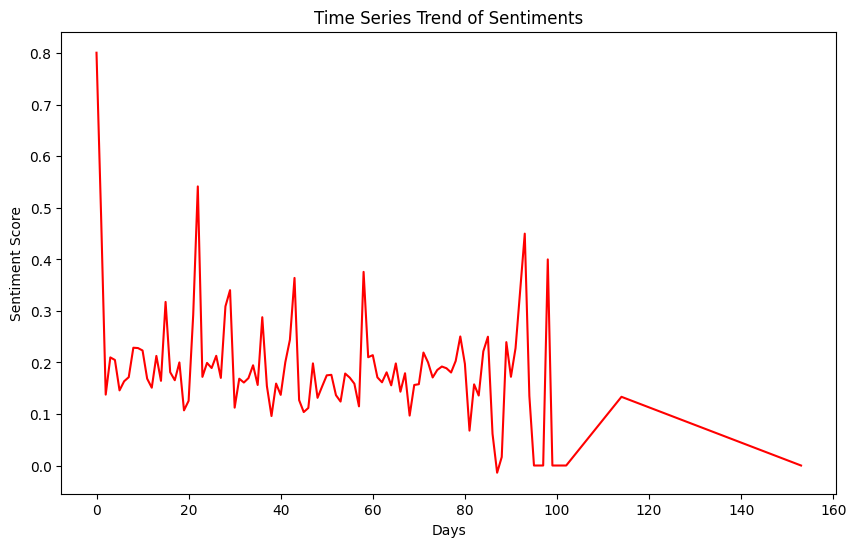

In [64]:
plt.figure(figsize=(10, 6),)
plt.plot(grouped['days'], grouped['sentiment'], color = 'red')
plt.xlabel('Days')
plt.ylabel('Sentiment Score')
plt.title('Time Series Trend of Sentiments')
plt.show()

In [65]:
# Convert DataFrame to JSON string
json_data = df.to_json(orient='records')

# Write JSON data to a file
with open('slack_data.json', 'w') as file:
    file.write(json_data)


## Creating mongodb database and collection

In [66]:
# Loading data from DataFrame to mongodb

# Connect to MongoDB server running on localhost
client = MongoClient('localhost', 27017)

# create a database
db = client['slack_data']

# create a collection
collection = db['all_slack_data']

with open('slack_data.json') as file:
    data = json.load(file)
    collection.insert_many(data)

client.close()

In [67]:
client = MongoClient('localhost', 27017)

db = client['slack_data']

collection = db.all_slack_data

# Fetch all documents in the collection
cursor = collection.find()

unique_channels = set()

for document in cursor:
    unique_channels.add(document.get('channel'))

# Print the unique channels
for channel in unique_channels:
    print(channel)

all-ml-week12
week4-teamwork
all-week9
batch6_week4_studygroup
all-ideas
all-broadcast
study-group
adludios-challange
week-11-group4
all-week10
all-week1
kafka_de
all-week2
happy-new-year-study-group
gokada-challenge-presentation
week-2-group-8
all-de-week12
ab_test-group
all-web3-week12
all-week7
chang-w11
all-week11
random
all-week4
all-week6
all-technical-support
all-career-exercises
all-week12
all-resources
dsa-sql
all-community-building
all-week8
all-week3
all-week5
team-10


## Creating postegresql database and tables

In [68]:
# creating a table for all channels data
engine = create_engine(f'postgresql://{user}:{encoded_password}@{server}/{database}')
table_name = 'all_slack_data'
df.to_sql(table_name, con=engine, if_exists='replace', index=False)

/tmp/ipykernel_63958/2602095446.py:4: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  df.to_sql(table_name, con=engine, if_exists='replace', index=False)


748

In [69]:
# Write the reaction DataFrame to reaction table
table_name = 'reaction'
reaction_df.to_sql(table_name, con=engine, if_exists='replace', index=False)

17

In [70]:
user_df = pd.read_json("../src/anonymized/users.json")
# user_df

In [72]:
# Write the user DataFrame to user table
table_name = 'user'
reaction_df.to_sql(table_name, con=engine, if_exists='replace', index=False)
engine.dispose()

In [73]:
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [74]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

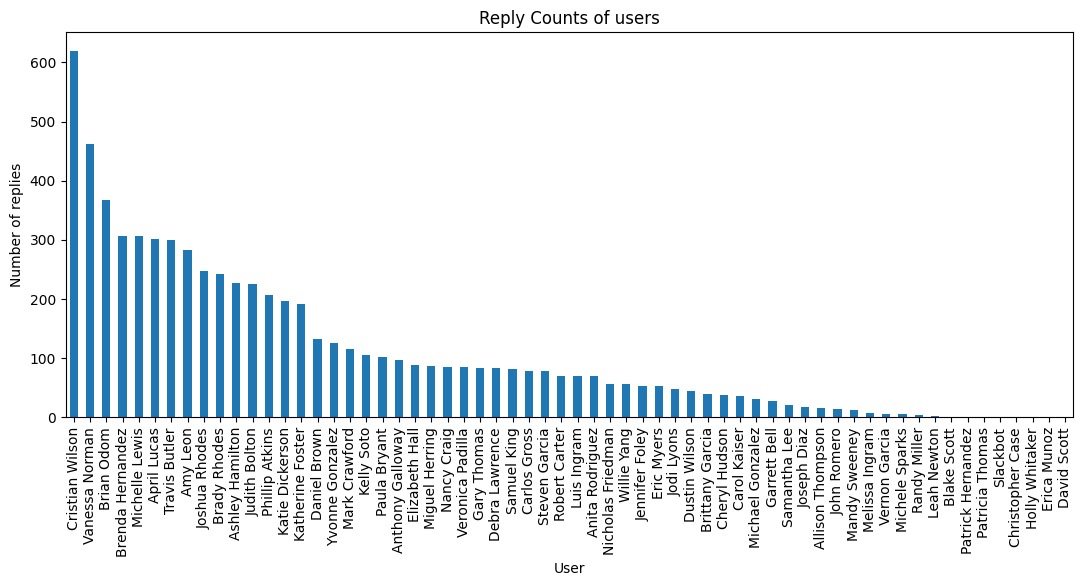

In [75]:
# which user has the highest number of reply counts?
def plot_highest_reply_count(data: DataFrame):
    gr_df = data.groupby('sender_name')['reply_count'].sum()
    gr_df = gr_df.sort_values(ascending=False)
    gr_df.plot(kind='bar', figsize=(13, 5))
    
    plt.title('Reply Counts of users')
    plt.xlabel('User')
    plt.ylabel('Number of replies')
    plt.show()

plot_highest_reply_count(df)

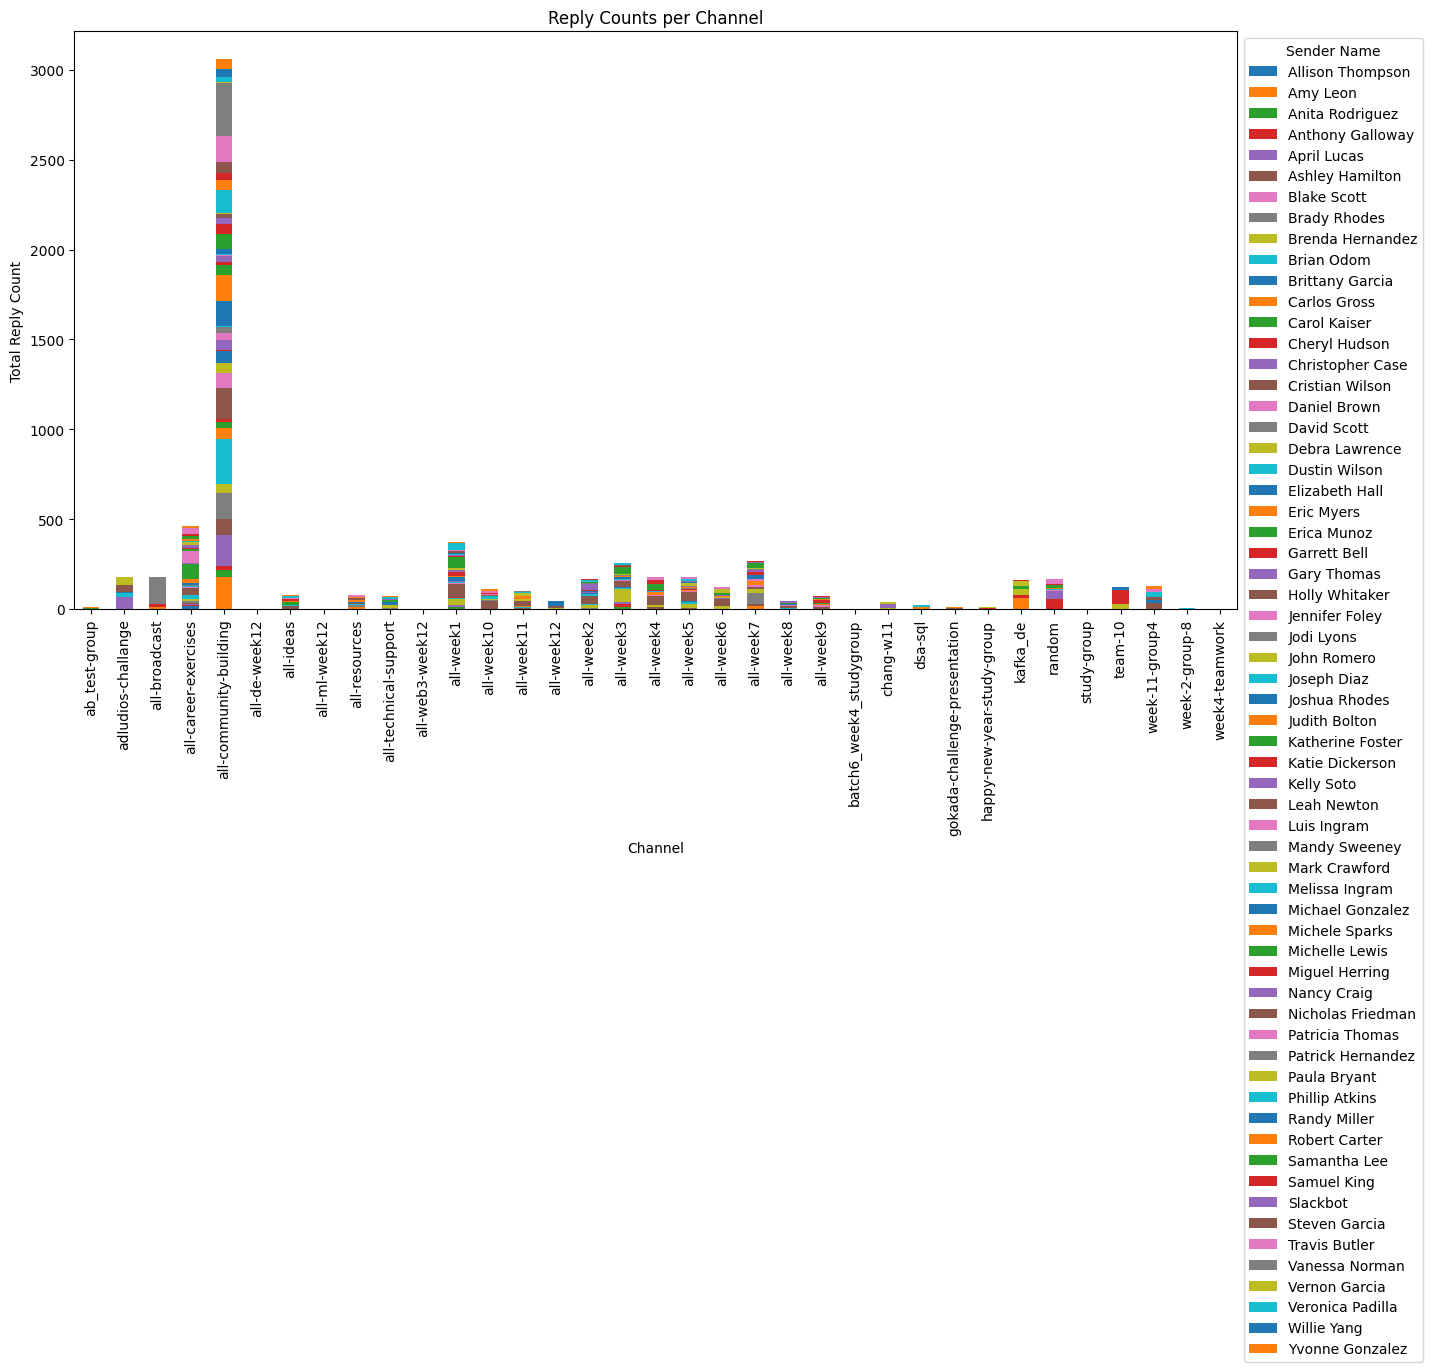

In [76]:
# Visualize reply counts per user per channel
def reply_per_user_per_channel(data: DataFrame):
    gr_df = data.groupby(['channel', 'sender_name'])['reply_count'].sum().unstack()
    gr_df.plot(kind='bar', figsize=(15, 7.5), stacked=True)
    
    plt.title('Reply Counts per Channel')
    plt.xlabel('Channel')
    plt.ylabel('Total Reply Count')
    plt.legend(title='Sender Name', bbox_to_anchor=(1, 1))
    plt.show()

    
reply_per_user_per_channel(df)


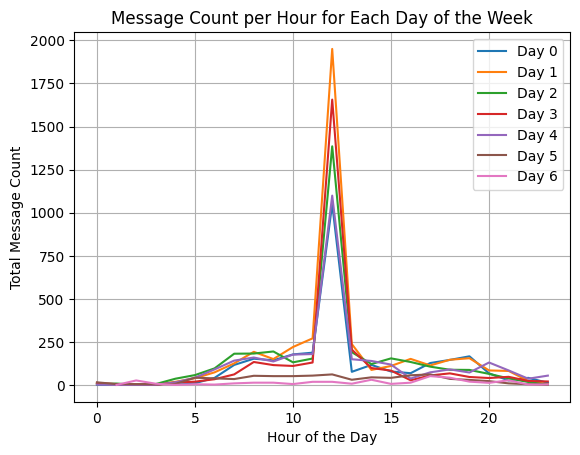

In [77]:
# what is the time range of the day that most messages are sent?
def plot_time_range(data: DataFrame):
    data = data.copy()  # Create a copy of the DataFrame
    
    # Convert 'msg_sent_time' to datetime if it's not already
    data['msg_sent_time'] = pd.to_datetime(data['msg_sent_time'], unit='s')
    
    # Set 'msg_sent_time' as the index
    data.set_index('msg_sent_time', inplace=True)
    
    # Extract hour and day of week from the index
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek
    
    # Group by hour and day of week and count the number of messages
    grouped = data.groupby(['day_of_week', 'hour']).size().reset_index(name='count')
    
    # Plot the data for each day of the week
    for day in range(7):
        subset = grouped[grouped['day_of_week'] == day]
        plt.plot(subset['hour'], subset['count'], label=f'Day {day}')
    
    plt.title('Message Count per Hour for Each Day of the Week')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Total Message Count')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_time_range(df)


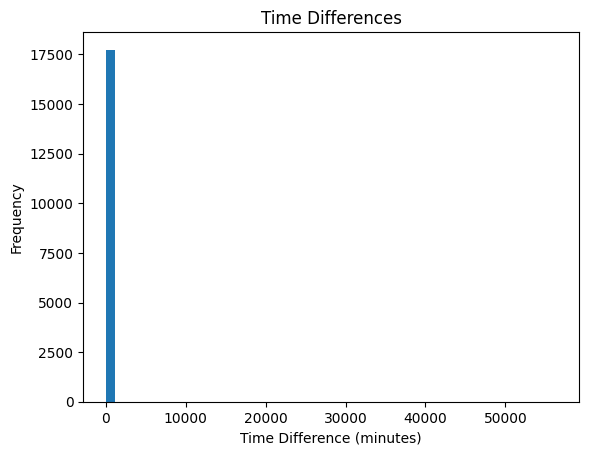

In [78]:
# what kind of messages are replied faster than others?
def plot_reply_time(data: DataFrame):
    data = data.copy()  # Create a copy of the DataFrame
    
    # Convert 'msg_sent_time' to datetime if it's not already
    data['msg_sent_time'] = pd.to_datetime(data['msg_sent_time'], unit='s')
    
    # Set 'msg_sent_time' as the index
    data.set_index('msg_sent_time', inplace=True)
    
    # Calculate the time difference between messages
    data['time_diff'] = data.index.to_series().diff()
    
    # Convert time difference to minutes
    data['time_diff_minutes'] = data['time_diff'].dt.total_seconds() / 60
    
    # Plot a histogram of the time differences
    plt.hist(data['time_diff_minutes'].dropna(), bins=50)
    plt.title('Time Differences')
    plt.xlabel('Time Difference (minutes)')
    plt.ylabel('Frequency')
    plt.show()

plot_reply_time(df)

In [15]:
# Relationship between # of messages and # of reactions

In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [33]:
# Model topics mentioned in the channel


In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?